In [22]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import legacy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [23]:
data_dir = "./dataset/"
data_dir = pathlib.Path(data_dir)

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


In [25]:
img_height = 150
img_width = 150

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=92)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=92)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


2024-03-21 19:02:10.880672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


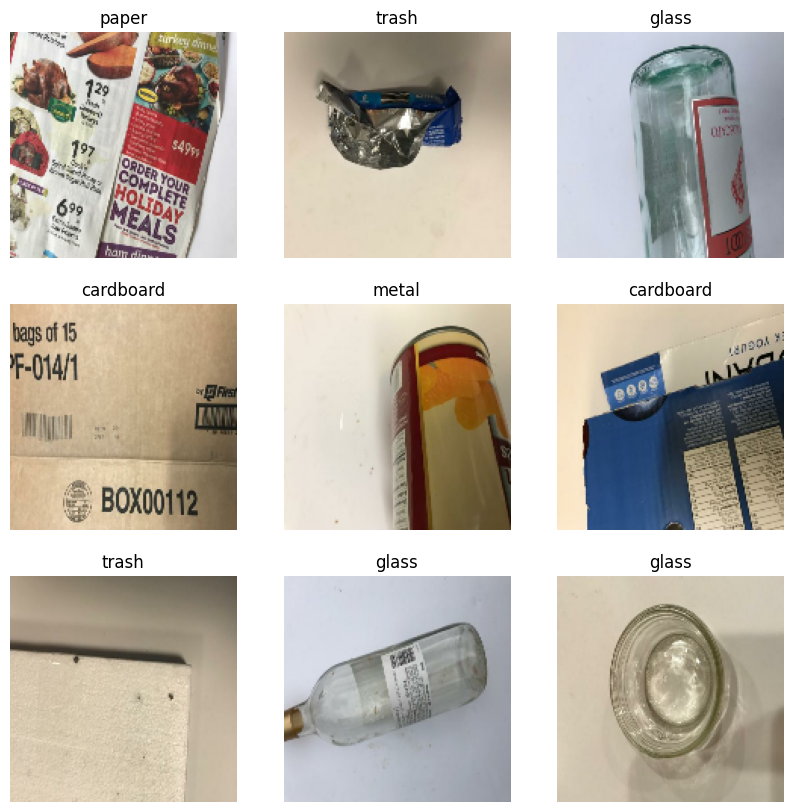

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i, (image, label) in enumerate(zip(images[:9], labels[:9])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.image.resize(image, (img_height, img_width)).numpy().astype("uint8"))
        plt.title(class_names[label])
        plt.axis("off")

plt.show()

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
normalization_layer = layers.Rescaling(1./255)

In [32]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [33]:
num_classes = len(class_names)

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-03-21 19:02:14.897052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


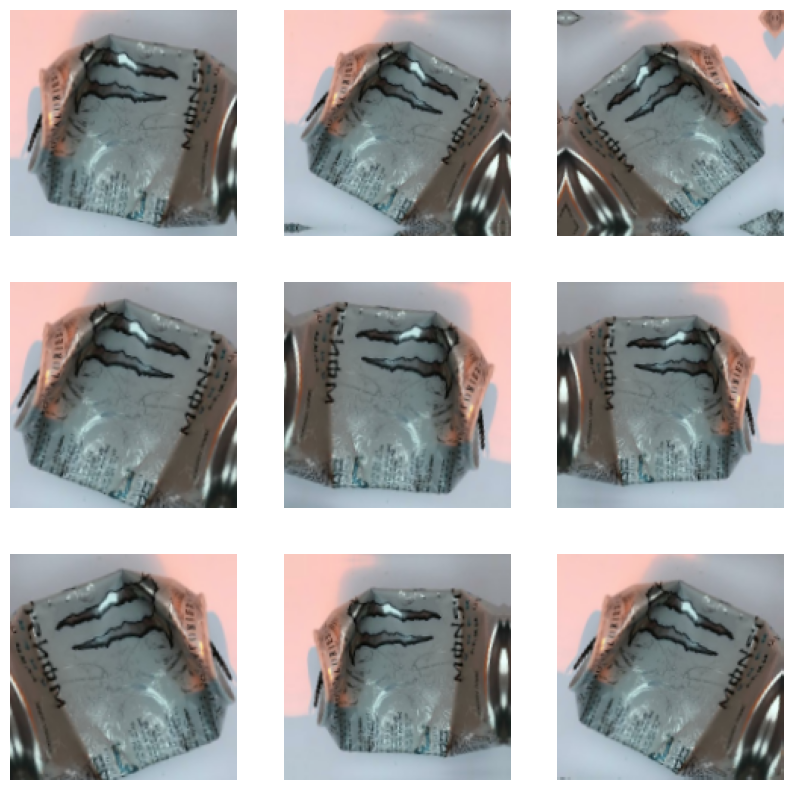

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
model = Sequential([
    data_augmentation,  # Séquence d'augmentation de données
    layers.Rescaling(1./255),  # Normalisation des valeurs des pixels
    layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [37]:
from tensorflow.keras.optimizers import Adam

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.0004)

# Compile the model using this optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
epochs = 20
batch_size = 64
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2286 - loss: 1.7354 - val_accuracy: 0.3584 - val_loss: 1.5230
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3977 - loss: 1.4752 - val_accuracy: 0.4356 - val_loss: 1.3491
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4642 - loss: 1.3221 - val_accuracy: 0.5307 - val_loss: 1.2455
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4984 - loss: 1.2622 - val_accuracy: 0.5525 - val_loss: 1.2268
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5564 - loss: 1.1483 - val_accuracy: 0.5525 - val_loss: 1.1498
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5963 - loss: 1.0741 - val_accuracy: 0.5564 - val_loss: 1.1482
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6193 - loss: 1.0269 - val_accuracy: 0.5762 - val_loss: 1.1571
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6143 - loss: 1.0313 - val_accuracy: 0.6020 - val_loss:

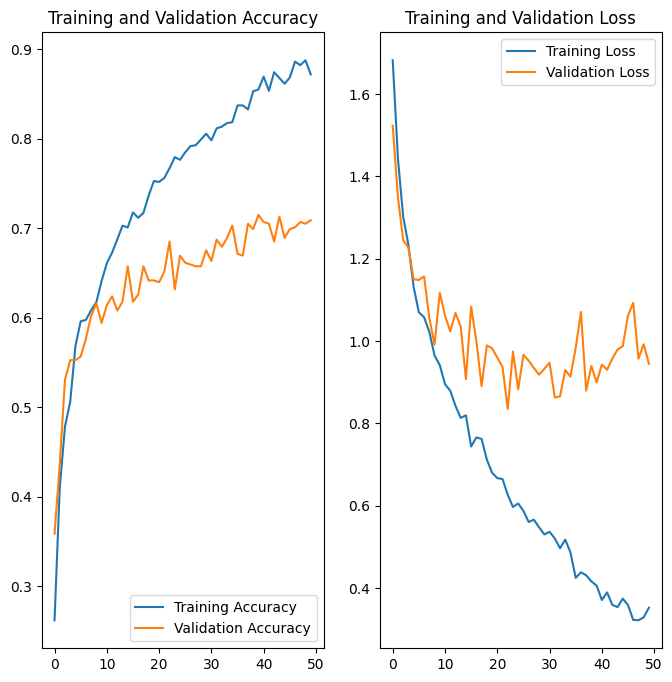

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
model.save('trash.keras')

In [42]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# Charger le modèle pré-entraîné
model_trained = load_model('trash.keras')

# img_path = getRandomPath() 
img_path = "cardboard220.jpg"
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Normalize the image
normalized_img = normalization_layer(img_array)

# Make prediction
predictions = model.predict(normalized_img)
# Afficher les probabilités de chaque classe
print(predictions)

# Déterminer la classe prédite en fonction de la probabilité maximale
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Afficher la classe prédite
print("Classe prédite:", predicted_class)

FileNotFoundError: [Errno 2] No such file or directory: 'cardboard220.jpg'